# Browser Automation, Code Interpreter & RAG

Beyond MCP: Built-in tools for web scraping, data viz, and document search.

In [1]:
import os, sys, subprocess
from pathlib import Path
from dotenv import load_dotenv

subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "python-dotenv", "azure-ai-projects==1.0.0", "azure-ai-agents==1.2.0b4", "azure-identity", "matplotlib"])

load_dotenv('.env')
print("✓ Dependencies installed")

✓ Dependencies installed



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


## 1. Browser Automation - Web Scraping
Managed Playwright browser for sites without APIs.

In [2]:
from azure.identity import DefaultAzureCredential
from azure.ai.projects import AIProjectClient
from azure.ai.agents.models import BrowserAutomationTool
import time

project_client = AIProjectClient(endpoint=os.getenv("PROJECT_ENDPOINT"), credential=DefaultAzureCredential())

browser_tool = BrowserAutomationTool(connection_id=os.getenv("AZURE_PLAYWRIGHT_CONNECTION_ID"))

agent = project_client.agents.create_agent(
    model=os.getenv("MODEL_DEPLOYMENT_NAME"),
    name="cpsc-recall-monitor",
    instructions="Check CPSC.gov for product recalls. Navigate, search, extract data concisely.",
    tools=browser_tool.definitions
)

thread = project_client.agents.threads.create()
project_client.agents.messages.create(
    thread_id=thread.id,
    role="user",
    content="Check https://www.cpsc.gov/Recalls for power bank recalls. List product names, dates, and hazards."
)

run = project_client.agents.runs.create(thread_id=thread.id, agent_id=agent.id)

while run.status in ["queued", "in_progress", "requires_action"]:
    time.sleep(2)
    run = project_client.agents.runs.get(thread_id=thread.id, run_id=run.id)

messages = list(project_client.agents.messages.list(thread_id=thread.id))


print (messages)


input_text = ""
for msg in messages:
    if msg.role == "assistant" and msg.text_messages:
        input_text += msg.text_messages[-1].text.value + "\n"

print("Agent Response:\n", input_text)

[{'id': 'msg_RCu8FoeEfHQcBmSvZYSJoFH2', 'object': 'thread.message', 'created_at': 1759856411, 'assistant_id': 'asst_QQiOP6WeRBw0hXNkhu2uZ3GN', 'thread_id': 'thread_0sp3FaEiSUZ2dRU75WCZvBKO', 'run_id': 'run_Tvsib4URjqFjyg627zXrjfr2', 'role': 'assistant', 'content': [{'type': 'image_file', 'image_file': {'file_id': 'assistant-DnSnPFFVeNKRsdp86Hasi4'}}, {'type': 'text', 'text': {'value': 'Here are the current power bank product recalls listed on the U.S. Consumer Product Safety Commission (CPSC) Recalls page:\n\n1. **Kogalla Power Banks (BatPak1, BatPak 2F, BatPak 3F)**\n   - **Recall Date:** October 02, 2025\n   - **Hazard:** The recalled power banks’ lithium-ion batteries can overheat and ignite, even when not in use, posing fire and burn hazards.\n\n2. **Aeiusny Power Stations**\n   - **Recall Date:** September 04, 2025\n   - **Hazard:** The internal lithium-ion battery can explode and ignite, posing a fire hazard and risk of serious injury or death.\n\nSource: [CPSC Recalls](https://w

## 2. Code Interpreter - Data Visualization
Agent writes Python code to create charts from scraped data.

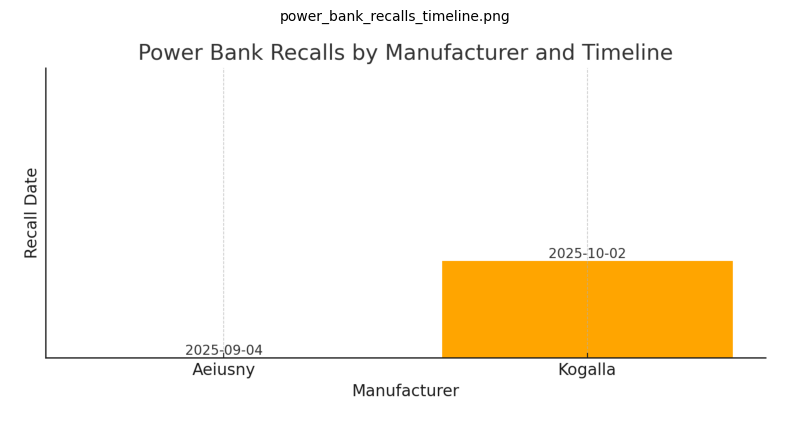

In [3]:
from azure.ai.agents.models import CodeInterpreterTool, MessageRole
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

code_interpreter_tool = CodeInterpreterTool()
viz_agent = project_client.agents.create_agent(
    model=os.getenv("MODEL_DEPLOYMENT_NAME"),
    name="data-viz-agent",
    instructions="Create matplotlib charts. Label axes, add titles. You must always produce an image file (PNG) and provide the file path.",
    tools=code_interpreter_tool.definitions,
    tool_resources=code_interpreter_tool.resources
)
viz_thread = project_client.agents.threads.create()
project_client.agents.messages.create(
    thread_id=viz_thread.id,
    role=MessageRole.USER,
    content=f"Create bar chart showing recalls by manufacturer and timeline from: {input_text} - Store it as a PNG file and provide the file path. You must always produce an image file / visualization! (Even if there are no recalls)"
)
viz_run = project_client.agents.runs.create_and_process(thread_id=viz_thread.id, agent_id=viz_agent.id)


output_dir = Path("/workspaces/mcp-in-action/")
output_dir.mkdir(exist_ok=True)

# Collect file annotations with their IDs
file_annotations = []
for msg in project_client.agents.messages.list(thread_id=viz_thread.id):
    if msg.role == "assistant":
        for t in msg.text_messages:
            for a in getattr(t.text, "annotations", []):
                if a.type == "file_path":
                    file_annotations.append((a.file_path.file_id, output_dir / Path(a.text).name))

# Save files using the collected annotations
for file_id, file_path in file_annotations:
    project_client.agents.files.save(file_id=file_id, file_name=str(file_path))

# Display the saved images
if file_annotations:
    saved_files = [fp for _, fp in file_annotations]
    fig, axes = plt.subplots(1, len(saved_files), figsize=(8*len(saved_files), 6))
    axes = [axes] if len(saved_files) == 1 else axes
    for ax, p in zip(axes, saved_files):
        ax.imshow(mpimg.imread(p))
        ax.axis("off")
        ax.set_title(p.name, fontsize=10)
    plt.tight_layout()
    plt.show()

## 3. File Search (RAG) - Document Q&A
Vector search over uploaded PDFs with citations.

In [4]:
import urllib.request
from azure.ai.agents.models import FilePurpose, FileSearchTool, ListSortOrder

doc_url = "https://eur-lex.europa.eu/legal-content/EN/TXT/PDF/?uri=CELEX:32006L0042"
doc_path = Path("/workspaces/mcp-in-action/machinery_directive.pdf")

urllib.request.urlretrieve(doc_url, doc_path)

uploaded_file = project_client.agents.files.upload_and_poll(file_path=str(doc_path), purpose=FilePurpose.AGENTS)
vector_store = project_client.agents.vector_stores.create_and_poll(file_ids=[uploaded_file.id], name="machinery-directive-store")

file_search_tool = FileSearchTool(vector_store_ids=[vector_store.id])

rag_agent = project_client.agents.create_agent(
    model=os.getenv("MODEL_DEPLOYMENT_NAME"),
    name="regulatory-advisor",
    instructions="Search documents for regulatory guidance. Cite sections.",
    tools=file_search_tool.definitions,
    tool_resources=file_search_tool.resources
)

rag_thread = project_client.agents.threads.create()
project_client.agents.messages.create(
    thread_id=rag_thread.id,
    role=MessageRole.USER,
    content="How should a manufacturer mark machinery for explosive atmospheres?"
)

rag_run = project_client.agents.runs.create_and_process(thread_id=rag_thread.id, agent_id=rag_agent.id)

rag_messages = list(project_client.agents.messages.list(thread_id=rag_thread.id, order=ListSortOrder.ASCENDING))

for msg in rag_messages:
    if msg.role == "assistant" and msg.text_messages:
        print(msg.text_messages[-1].text.value)
        if hasattr(msg.text_messages[-1].text, 'annotations'):
            annotations = msg.text_messages[-1].text.annotations
            if annotations:
                print("\n📚 SOURCES:")
                for idx, a in enumerate(annotations, 1):
                    if hasattr(a, 'file_citation'):
                        print(f"  [{idx}] {a.file_citation.file_id}")

A manufacturer must mark machinery intended for use in explosive atmospheres according to specific regulatory requirements. Based on relevant guidance, the following markings are required:

1. **CE Marking**: The machinery must display the CE mark to show compliance with applicable EU Directives, such as the ATEX Directive.
2. **Explosion Protection Marking**: The machinery should have the “Ex” symbol, which indicates suitability for explosive atmospheres.
3. **Specific Information**: Markings should also include:
   - The name and address of the manufacturer
   - The type, batch or serial number
   - The specific equipment group and category (e.g., II 2G for equipment intended for use in gas explosive atmospheres in Zone 1)
   - The symbol of the equipment protection level (EPL), if applicable
   - Other relevant safety information, such as temperature class and protection method

Markings must be **permanent, legible, and indelible**, situated on a part of the machinery that is clear

## Cleanup

In [5]:
project_client.agents.delete_agent(agent.id)
project_client.agents.delete_agent(viz_agent.id)
project_client.agents.delete_agent(rag_agent.id)
project_client.agents.files.delete(uploaded_file.id)
project_client.agents.vector_stores.delete(vector_store.id)
project_client.close()
print("✓ Cleanup complete")

✓ Cleanup complete


## Summary

**Tool Types:**
- **Browser Automation**: Scrape websites (no API needed)
- **Code Interpreter**: Execute Python, generate charts
- **File Search (RAG)**: Semantic search over documents with citations

**When to Use:**
- Browser: Public sites designed for humans
- Code Interpreter: Data analysis, visualization
- File Search: Large docs, regulatory compliance
- MCP: Internal systems, custom business logic